# Importing Libraries

In [1]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 18.9 MB/s eta 0:00:00


In [2]:
import pickle 
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Importing Pickle file of Subject 2

In [3]:
file_path = "/kaggle/input/wesad-full-dataset/WESAD/S2/S2.pkl"

with open(file_path, "rb") as file:
    s2 = pickle.load(file, encoding="latin1")

print(s2)


{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682],
       [-1.12457275],
       

## Preprocessing Subject 2
We will focus on the data from RespiBAN (chest device).
Heart rate (HR), EDA, and Respiration are the key features related to stress. We will extract the HR from the ECG data and then synchronize it with the EDA, respiration, and Labels. We will extract Mean,STD,Min,Max from each feature in each window. Finally, we'll organize everything into a data frame to prepare it for input into the model.

In [4]:
s2_ecg_signal = s2["signal"]["chest"]["ECG"]
s2_eda_signal = s2["signal"]["chest"]["EDA"]
s2_resp_signal = s2["signal"]["chest"]["Resp"]
s2_labels = s2["label"]

# Flatten the data (make it 1D array)
s2_ecg_signal = s2_ecg_signal.flatten()
s2_eda_signal = s2_eda_signal.flatten()
s2_resp_signal = s2_resp_signal.flatten()

# Sampling Rates (All signals were sampled at 700 Hz) and Preparing window size and the number of values in each window
frequency = 700  # Hz
windows_size = 60  # Seconds
no_of_values_in_window = windows_size * frequency

# Noise Reduction
s2_ecg_cleaned = nk.ecg_clean(s2_ecg_signal, sampling_rate=frequency)

# Finding R-Peaks
s2_r_peaks, _ = signal.find_peaks(s2_ecg_cleaned, distance=frequency*0.6, height=np.mean(s2_ecg_cleaned))

# Calculate HR in Beats Per Minute (BPM)
s2_rr_intervals = np.diff(s2_r_peaks) / frequency 
s2_hr_bpm = 60 / s2_rr_intervals  

# Upsampling HR to be the same number of values of EDA
s2_hr_bpm_resampled = np.interp(np.arange(len(s2_ecg_signal)), s2_r_peaks[1:], s2_hr_bpm)

# Total number of windows in the subject
total_no_of_windows = len(s2_ecg_signal) // no_of_values_in_window

# Feature Extraction
s2_features=[]

for i in range(total_no_of_windows):      
    start = i * no_of_values_in_window
    end = start + no_of_values_in_window    # About 13,300 values are dropped, Or less than one minute of values are dropped

    # Window Extraction
    s2_hr_window = s2_hr_bpm_resampled[start:end]
    s2_eda_window = s2_eda_signal[start:end]
    s2_resp_window = s2_resp_signal[start:end]
    s2_label_window = s2_labels[start:end]

    # HR Features
    s2_mean_hr = np.mean(s2_hr_window)
    s2_std_hr = np.std(s2_hr_window)
    s2_min_hr = np.min(s2_hr_window)
    s2_max_hr = np.max(s2_hr_window)

    # EDA Features
    s2_mean_eda = np.mean(s2_eda_window)
    s2_std_eda = np.std(s2_eda_window)
    s2_min_eda = np.min(s2_eda_window)
    s2_max_eda = np.max(s2_eda_window)

    # Respiration Features
    s2_mean_resp = np.mean(s2_resp_window)
    s2_std_resp = np.std(s2_resp_window)
    s2_min_resp = np.min(s2_resp_window)
    s2_max_resp = np.max(s2_resp_window)

    # Most Frequent Label 
    s2_label = np.bincount(s2_label_window).argmax()

    # Arrange features of each window in list of dictionaries
    s2_features.append({
        "Subject_ID": 's2',
        "Mean_HR": s2_mean_hr,
        "STD_HR": s2_std_hr,
        "Min_HR": s2_min_hr,
        "Max_HR": s2_max_hr,
        "Mean_EDA": s2_mean_eda,
        "STD_EDA": s2_std_eda,
        "Min_EDA": s2_min_eda,
        "Max_EDA": s2_max_eda,
        "Mean_Resp": s2_mean_resp,
        "STD_Resp": s2_std_resp,
        "Min_Resp": s2_min_resp,
        "Max_Resp": s2_max_resp,
        "Label": s2_label
        })
    
# DataFraming the list of features
s2_df = pd.DataFrame(s2_features)

# Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
s2_df.Label = s2_df.Label.replace([1, 3, 4], 0)
s2_df.Label = s2_df.Label.replace([2, 5, 6, 7], 1)

In [5]:
s2_df

,Subject_ID,Mean_HR,STD_HR,Min_HR,Max_HR,Mean_EDA,STD_EDA,Min_EDA,Max_EDA,Mean_Resp,STD_Resp,Min_Resp,Max_Resp,Label
0,s2,76.120209,7.885929,60.869565,94.382022,5.514064,0.267056,4.918289,6.488419,0.044542,2.469886,-7.615662,8.067322,0
1,s2,75.938033,4.728132,65.318818,92.715232,5.466576,0.293679,5.014801,6.514359,0.091874,2.804811,-6.935120,7.417297,0
2,s2,74.485751,5.868237,61.046512,92.920354,5.667365,0.578884,4.928207,6.937027,0.052686,2.619609,-6.767273,7.875061,0
3,s2,75.277291,5.796105,63.732929,91.503268,5.816682,0.364125,5.259705,6.766891,0.003717,3.175039,-11.737061,7.942200,0
4,s2,72.250905,6.362081,61.946903,89.552239,6.157064,0.535107,5.316544,7.576752,0.153010,2.636589,-7.829285,5.625916,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,s2,62.630484,3.499547,55.118110,81.395349,0.483940,0.023704,0.425339,0.641251,0.048566,1.108108,-2.659607,2.467346,0
97,s2,64.638814,5.230415,52.963430,80.000000,0.472144,0.023167,0.263214,0.611115,0.044946,1.414177,-3.501892,3.062439,0
98,s2,64.478658,7.533837,54.123711,99.526066,0.498261,0.034447,0.363541,0.684357,0.075795,4.578167,-22.044373,13.619995,0
99,s2,68.346394,7.531102,50.059595,96.774194,0.452482,0.040462,0.325012,0.637817,0.149558,4.393043,-20.451355,17.106628,0


101 rows = 101 windows

# Doint The Same Preprocessing Steps For All Subjects

## Subject 3

### Importing Pickle file

In [6]:
with open('/kaggle/input/wesad-full-dataset/WESAD/S3/S3.pkl', "rb") as file:
    s3 = pickle.load(file, encoding="latin1")

### Preprocessing

In [7]:
s3_ecg_signal = s3["signal"]["chest"]["ECG"]
s3_eda_signal = s3["signal"]["chest"]["EDA"]
s3_resp_signal = s3["signal"]["chest"]["Resp"]
s3_labels = s3["label"]

# Flatten the data (make it 1D array)
s3_ecg_signal = s3_ecg_signal.flatten()
s3_eda_signal = s3_eda_signal.flatten()
s3_resp_signal = s3_resp_signal.flatten()

# Noise Reduction
s3_ecg_cleaned = nk.ecg_clean(s3_ecg_signal, sampling_rate=frequency)

# Finding R-Peaks
s3_r_peaks, _ = signal.find_peaks(s3_ecg_cleaned, distance=frequency*0.6, height=np.mean(s3_ecg_cleaned))

# Calculate HR in Beats Per Minute (BPM)
s3_rr_intervals = np.diff(s3_r_peaks) / frequency 
s3_hr_bpm = 60 / s3_rr_intervals  

# Upsampling HR to be the same number of values of EDA
s3_hr_bpm_resampled = np.interp(np.arange(len(s3_ecg_signal)), s3_r_peaks[1:], s3_hr_bpm)

# Total number of windows in the subject
total_no_of_windows = len(s3_ecg_signal) // no_of_values_in_window

# Feature Extraction
s3_features=[]

for i in range(total_no_of_windows):      
    start = i * no_of_values_in_window
    end = start + no_of_values_in_window    

    # Window Extraction
    s3_hr_window = s3_hr_bpm_resampled[start:end]
    s3_eda_window = s3_eda_signal[start:end]
    s3_resp_window = s3_resp_signal[start:end]
    s3_label_window = s3_labels[start:end]

    # HR Features
    s3_mean_hr = np.mean(s3_hr_window)
    s3_std_hr = np.std(s3_hr_window)
    s3_min_hr = np.min(s3_hr_window)
    s3_max_hr = np.max(s3_hr_window)

    # EDA Features
    s3_mean_eda = np.mean(s3_eda_window)
    s3_std_eda = np.std(s3_eda_window)
    s3_min_eda = np.min(s3_eda_window)
    s3_max_eda = np.max(s3_eda_window)

    # Respiration Features
    s3_mean_resp = np.mean(s3_resp_window)
    s3_std_resp = np.std(s3_resp_window)
    s3_min_resp = np.min(s3_resp_window)
    s3_max_resp = np.max(s3_resp_window)

    # Most Frequent Label 
    s3_label = np.bincount(s3_label_window).argmax()

    # Arrange features of each window in list of dictionaries
    s3_features.append({
        "Subject_ID": 's3',
        "Mean_HR": s3_mean_hr,
        "STD_HR": s3_std_hr,
        "Min_HR": s3_min_hr,
        "Max_HR": s3_max_hr,
        "Mean_EDA": s3_mean_eda,
        "STD_EDA": s3_std_eda,
        "Min_EDA": s3_min_eda,
        "Max_EDA": s3_max_eda,
        "Mean_Resp": s3_mean_resp,
        "STD_Resp": s3_std_resp,
        "Min_Resp": s3_min_resp,
        "Max_Resp": s3_max_resp,
        "Label": s3_label
        })
    
# DataFraming the list of features
s3_df = pd.DataFrame(s3_features)

# Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
s3_df.Label = s3_df.Label.replace([1, 3, 4], 0)
s3_df.Label = s3_df.Label.replace([2, 5, 6, 7], 1)

In [8]:
s3_df

,Subject_ID,Mean_HR,STD_HR,Min_HR,Max_HR,Mean_EDA,STD_EDA,Min_EDA,Max_EDA,Mean_Resp,STD_Resp,Min_Resp,Max_Resp,Label
0,s3,63.497694,6.688786,48.611111,77.634011,10.049858,0.896145,7.977295,11.545181,0.068467,5.445968,-26.054382,19.256592,0
1,s3,69.171536,6.776903,57.142857,84.168337,14.134826,1.411098,11.481476,16.365433,0.056655,2.988515,-6.428528,7.637024,0
2,s3,71.408855,6.910612,56.987788,82.031250,9.210742,0.949852,7.601929,11.625290,0.013019,4.917530,-14.065552,13.499451,0
3,s3,68.571452,7.023964,53.777209,82.677165,7.319615,0.158125,6.918716,7.770920,0.042421,4.196948,-10.113525,11.851501,0
4,s3,69.387360,7.462876,48.554913,86.776860,6.947882,0.169376,6.448364,7.389069,0.145385,4.635894,-15.519714,14.668274,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,s3,59.946819,12.314525,42.042042,96.109840,7.136143,0.023584,7.037354,7.257462,-0.173169,6.135312,-14.698792,14.665222,0
104,s3,51.841527,4.274096,44.444444,65.727700,7.087926,0.031929,6.929398,7.208633,0.062555,1.869245,-3.900146,5.621338,0
105,s3,53.475060,9.018865,44.444444,98.591549,7.040318,0.016090,6.959534,7.191467,0.111606,2.961308,-10.472107,9.542847,0
106,s3,72.004678,15.050708,41.958042,95.890411,7.192484,0.148634,6.858444,7.474136,0.133573,4.778406,-13.348389,13.026428,0


## Subject 4

### Importing Pickle file

In [9]:
with open('/kaggle/input/wesad-full-dataset/WESAD/S4/S4.pkl', "rb") as file:
    s4 = pickle.load(file, encoding="latin1")

### Preprocessing

In [10]:
s4_ecg_signal = s4["signal"]["chest"]["ECG"]
s4_eda_signal = s4["signal"]["chest"]["EDA"]
s4_resp_signal = s4["signal"]["chest"]["Resp"]
s4_labels = s4["label"]

# Flatten the data (make it 1D array)
s4_ecg_signal = s4_ecg_signal.flatten()
s4_eda_signal = s4_eda_signal.flatten()
s4_resp_signal = s4_resp_signal.flatten()

# Noise Reduction
s4_ecg_cleaned = nk.ecg_clean(s4_ecg_signal, sampling_rate=frequency)

# Finding R-Peaks
s4_r_peaks, _ = signal.find_peaks(s4_ecg_cleaned, distance=frequency*0.6, height=np.mean(s4_ecg_cleaned))

# Calculate HR in Beats Per Minute (BPM)
s4_rr_intervals = np.diff(s4_r_peaks) / frequency 
s4_hr_bpm = 60 / s4_rr_intervals  

# Upsampling HR to be the same number of values of EDA
s4_hr_bpm_resampled = np.interp(np.arange(len(s4_ecg_signal)), s4_r_peaks[1:], s4_hr_bpm)

# Total number of windows in the subject
total_no_of_windows = len(s4_ecg_signal) // no_of_values_in_window

# Feature Extraction
s4_features=[]

for i in range(total_no_of_windows):      
    start = i * no_of_values_in_window
    end = start + no_of_values_in_window    

    # Window Extraction
    s4_hr_window = s4_hr_bpm_resampled[start:end]
    s4_eda_window = s4_eda_signal[start:end]
    s4_resp_window = s4_resp_signal[start:end]
    s4_label_window = s4_labels[start:end]

    # HR Features
    s4_mean_hr = np.mean(s4_hr_window)
    s4_std_hr = np.std(s4_hr_window)
    s4_min_hr = np.min(s4_hr_window)
    s4_max_hr = np.max(s4_hr_window)

    # EDA Features
    s4_mean_eda = np.mean(s4_eda_window)
    s4_std_eda = np.std(s4_eda_window)
    s4_min_eda = np.min(s4_eda_window)
    s4_max_eda = np.max(s4_eda_window)

    # Respiration Features
    s4_mean_resp = np.mean(s4_resp_window)
    s4_std_resp = np.std(s4_resp_window)
    s4_min_resp = np.min(s4_resp_window)
    s4_max_resp = np.max(s4_resp_window)

    # Most Frequent Label 
    s4_label = np.bincount(s4_label_window).argmax()

    # Arrange features of each window in list of dictionaries
    s4_features.append({
        "Subject_ID": 's4',
        "Mean_HR": s4_mean_hr,
        "STD_HR": s4_std_hr,
        "Min_HR": s4_min_hr,
        "Max_HR": s4_max_hr,
        "Mean_EDA": s4_mean_eda,
        "STD_EDA": s4_std_eda,
        "Min_EDA": s4_min_eda,
        "Max_EDA": s4_max_eda,
        "Mean_Resp": s4_mean_resp,
        "STD_Resp": s4_std_resp,
        "Min_Resp": s4_min_resp,
        "Max_Resp": s4_max_resp,
        "Label": s4_label
        })
    
# DataFraming the list of features
s4_df = pd.DataFrame(s4_features)

# Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
s4_df.Label = s4_df.Label.replace([1, 3, 4], 0)
s4_df.Label = s4_df.Label.replace([2, 5, 6, 7], 1)

In [11]:
s4_df

,Subject_ID,Mean_HR,STD_HR,Min_HR,Max_HR,Mean_EDA,STD_EDA,Min_EDA,Max_EDA,Mean_Resp,STD_Resp,Min_Resp,Max_Resp,Label
0,s4,71.013620,6.247483,60.085837,85.192698,1.586738,0.176267,1.083374,1.844788,0.057259,2.430116,-5.970764,5.403137,0
1,s4,64.887972,5.153300,54.123711,78.504673,1.636076,0.054422,1.478195,1.816177,0.058433,2.208700,-4.545593,5.889893,0
2,s4,65.365319,4.254200,52.697616,76.782450,1.517842,0.057034,1.334000,1.733398,0.011257,1.859988,-4.676819,5.137634,0
3,s4,67.554263,3.592773,60.957910,78.066914,1.372768,0.032863,1.138687,1.525497,0.192690,2.450963,-7.025146,6.980896,0
4,s4,69.860670,6.410867,56.375839,83.003953,1.304578,0.023877,1.108170,1.432800,0.034739,2.747167,-10.630798,7.356262,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,s4,64.640864,5.838901,52.896725,78.947368,2.560350,0.016612,2.367401,2.723694,0.029713,3.236895,-7.383728,12.330627,0
103,s4,63.523170,5.479406,52.109181,74.600355,2.557797,0.015690,2.215958,2.684784,0.062228,4.215332,-11.732483,12.347412,0
104,s4,69.821613,8.746467,52.697616,92.920354,2.518402,0.021430,2.320862,2.637482,-0.049224,3.681189,-10.621643,8.863831,0
105,s4,60.130677,4.115654,48.951049,68.403909,2.565695,0.015992,2.359009,2.701950,0.153043,2.244401,-5.973816,6.809998,0


## Subject 5

### Importing Pickle file

In [12]:
with open('/kaggle/input/wesad-full-dataset/WESAD/S5/S5.pkl', "rb") as file:
    s5 = pickle.load(file, encoding="latin1")

### Preprocessing

In [13]:
s5_ecg_signal = s5["signal"]["chest"]["ECG"]
s5_eda_signal = s5["signal"]["chest"]["EDA"]
s5_resp_signal = s5["signal"]["chest"]["Resp"]
s5_labels = s5["label"]

# Flatten the data (make it 1D array)
s5_ecg_signal = s5_ecg_signal.flatten()
s5_eda_signal = s5_eda_signal.flatten()
s5_resp_signal = s5_resp_signal.flatten()

# Noise Reduction
s5_ecg_cleaned = nk.ecg_clean(s5_ecg_signal, sampling_rate=frequency)

# Finding R-Peaks
s5_r_peaks, _ = signal.find_peaks(s5_ecg_cleaned, distance=frequency*0.6, height=np.mean(s5_ecg_cleaned))

# Calculate HR in Beats Per Minute (BPM)
s5_rr_intervals = np.diff(s5_r_peaks) / frequency 
s5_hr_bpm = 60 / s5_rr_intervals  

# Upsampling HR to be the same number of values of EDA
s5_hr_bpm_resampled = np.interp(np.arange(len(s5_ecg_signal)), s5_r_peaks[1:], s5_hr_bpm)

# Total number of windows in the subject
total_no_of_windows = len(s5_ecg_signal) // no_of_values_in_window

# Feature Extraction
s5_features=[]

for i in range(total_no_of_windows):      
    start = i * no_of_values_in_window
    end = start + no_of_values_in_window    

    # Window Extraction
    s5_hr_window = s5_hr_bpm_resampled[start:end]
    s5_eda_window = s5_eda_signal[start:end]
    s5_resp_window = s5_resp_signal[start:end]
    s5_label_window = s5_labels[start:end]

    # HR Features
    s5_mean_hr = np.mean(s5_hr_window)
    s5_std_hr = np.std(s5_hr_window)
    s5_min_hr = np.min(s5_hr_window)
    s5_max_hr = np.max(s5_hr_window)

    # EDA Features
    s5_mean_eda = np.mean(s5_eda_window)
    s5_std_eda = np.std(s5_eda_window)
    s5_min_eda = np.min(s5_eda_window)
    s5_max_eda = np.max(s5_eda_window)

    # Respiration Features
    s5_mean_resp = np.mean(s5_resp_window)
    s5_std_resp = np.std(s5_resp_window)
    s5_min_resp = np.min(s5_resp_window)
    s5_max_resp = np.max(s5_resp_window)

    # Most Frequent Label 
    s5_label = np.bincount(s5_label_window).argmax()

    # Arrange features of each window in list of dictionaries
    s5_features.append({
        "Subject_ID": 's5',
        "Mean_HR": s5_mean_hr,
        "STD_HR": s5_std_hr,
        "Min_HR": s5_min_hr,
        "Max_HR": s5_max_hr,
        "Mean_EDA": s5_mean_eda,
        "STD_EDA": s5_std_eda,
        "Min_EDA": s5_min_eda,
        "Max_EDA": s5_max_eda,
        "Mean_Resp": s5_mean_resp,
        "STD_Resp": s5_std_resp,
        "Min_Resp": s5_min_resp,
        "Max_Resp": s5_max_resp,
        "Label": s5_label
        })
    
# DataFraming the list of features
s5_df = pd.DataFrame(s5_features)

# Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
s5_df.Label = s5_df.Label.replace([1, 3, 4], 0)
s5_df.Label = s5_df.Label.replace([2, 5, 6, 7], 1)

In [14]:
s5_df

,Subject_ID,Mean_HR,STD_HR,Min_HR,Max_HR,Mean_EDA,STD_EDA,Min_EDA,Max_EDA,Mean_Resp,STD_Resp,Min_Resp,Max_Resp,Label
0,s5,72.882141,5.116652,62.593145,93.541203,4.265185,0.116489,3.795242,4.519653,0.062034,5.090181,-15.489197,23.904419,0
1,s5,68.182638,3.750230,61.946903,77.064220,5.136796,0.472698,4.199600,5.892181,0.109643,5.405532,-9.703064,17.437744,0
2,s5,67.684559,2.791527,61.674009,73.920303,6.316837,0.614077,5.548477,7.762146,-0.085858,5.231481,-21.168518,10.162354,0
3,s5,70.021733,5.615421,61.493411,85.539715,7.004178,0.307394,6.529617,7.873917,0.173273,6.133140,-11.503601,29.728699,0
4,s5,66.288392,7.228474,55.555556,81.237911,6.483510,0.268306,5.995178,7.137299,-0.095790,5.049520,-15.296936,15.354919,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,s5,66.927292,2.949066,60.957910,73.555166,6.906793,0.131128,6.477737,7.240295,0.065230,3.901439,-8.815002,9.877014,0
100,s5,70.011494,6.727373,57.692308,82.677165,8.180014,0.394984,6.883621,8.713913,0.117819,5.108999,-16.313171,15.034485,0
101,s5,65.553979,4.419037,56.987788,75.675676,8.723406,0.151266,8.413315,9.286880,0.100027,4.588808,-12.167358,16.114807,0
102,s5,73.153613,7.720544,63.063063,89.171975,9.258969,0.726270,8.485413,10.899734,0.025134,3.902861,-18.875122,11.677551,0


## Subject 6 : Subject 17

In [15]:
all_features = []

for i in range(6, 18):
    
    # Check if the subject exists
    if os.path.isdir('/kaggle/input/wesad-full-dataset/WESAD/S'+str(i)):
        pkl_path = '/kaggle/input/wesad-full-dataset/WESAD/S'+str(i)+'/S'+str(i)+'.pkl'

        # Importing Pickle file
        with open(pkl_path, "rb") as file:
            s = pickle.load(file, encoding="latin1")

        ### Preprocessing ###
        s_ecg_signal = s["signal"]["chest"]["ECG"]
        s_eda_signal = s["signal"]["chest"]["EDA"]
        s_resp_signal = s["signal"]["chest"]["Resp"]
        s_labels = s["label"]

        # Flatten the data (make it 1D array)
        s_ecg_signal = s_ecg_signal.flatten()
        s_eda_signal = s_eda_signal.flatten()
        s_resp_signal = s_resp_signal.flatten()

        # Noise Reduction
        s_ecg_cleaned = nk.ecg_clean(s_ecg_signal, sampling_rate=frequency)

        # Finding R-Peaks
        s_r_peaks, _ = signal.find_peaks(s_ecg_cleaned, distance=frequency*0.6, height=np.mean(s_ecg_cleaned))

        # Calculate HR in Beats Per Minute (BPM)
        s_rr_intervals = np.diff(s_r_peaks) / frequency 
        s_hr_bpm = 60 / s_rr_intervals  

        # Upsampling HR to be the same number of values of EDA
        s_hr_bpm_resampled = np.interp(np.arange(len(s_ecg_signal)), s_r_peaks[1:], s_hr_bpm)

        # Total number of windows in the subject
        total_no_of_windows = len(s_ecg_signal) // no_of_values_in_window

        # Feature Extraction
        s_features=[]

        for j in range(total_no_of_windows):      
            start = j * no_of_values_in_window
            end = start + no_of_values_in_window    

            # Window Extraction
            s_hr_window = s_hr_bpm_resampled[start:end]
            s_eda_window = s_eda_signal[start:end]
            s_resp_window = s_resp_signal[start:end]
            s_label_window = s_labels[start:end]

            # HR Features
            s_mean_hr = np.mean(s_hr_window)
            s_std_hr = np.std(s_hr_window)
            s_min_hr = np.min(s_hr_window)
            s_max_hr = np.max(s_hr_window)

            # EDA Features
            s_mean_eda = np.mean(s_eda_window)
            s_std_eda = np.std(s_eda_window)
            s_min_eda = np.min(s_eda_window)
            s_max_eda = np.max(s_eda_window)

            # Respiration Features
            s_mean_resp = np.mean(s_resp_window)
            s_std_resp = np.std(s_resp_window)
            s_min_resp = np.min(s_resp_window)
            s_max_resp = np.max(s_resp_window)

            # Most Frequent Label 
            s_label = np.bincount(s_label_window).argmax()

            # Arrange features of each window in list of dictionaries
            s_features.append({
                "Subject_ID": 's'+str(i),
                "Mean_HR": s_mean_hr,
                "STD_HR": s_std_hr,
                "Min_HR": s_min_hr,
                "Max_HR": s_max_hr,
                "Mean_EDA": s_mean_eda,
                "STD_EDA": s_std_eda,
                "Min_EDA": s_min_eda,
                "Max_EDA": s_max_eda,
                "Mean_Resp": s_mean_resp,
                "STD_Resp": s_std_resp,
                "Min_Resp": s_min_resp,
                "Max_Resp": s_max_resp,
                "Label": s_label
                })
    
        # DataFraming the list of features of the subject
        s_df = pd.DataFrame(s_features)

        # Make Labels 1,3,4 Not Stress, and 2,5,6,7 Stress
        s_df.Label = s_df.Label.replace([1, 3, 4], 0)
        s_df.Label = s_df.Label.replace([2, 5, 6, 7], 1)

    # Arrange DataFrame of each subject in list of DataFrames
    all_features.append(s_df)

# The DataFrame of subject 6 : subject 17
from_6_to_17_df = pd.concat(all_features, ignore_index=True)

In [16]:
from_6_to_17_df

,Subject_ID,Mean_HR,STD_HR,Min_HR,Max_HR,Mean_EDA,STD_EDA,Min_EDA,Max_EDA,Mean_Resp,STD_Resp,Min_Resp,Max_Resp,Label
0,s6,76.466759,5.612895,62.222222,89.171975,10.498158,0.400154,9.770584,11.530685,0.203108,6.089170,-18.182373,19.844055,0
1,s6,75.711859,5.751979,61.855670,87.500000,10.909989,0.254647,10.507584,11.594009,0.070502,4.802530,-17.567444,17.445374,0
2,s6,69.136286,3.183198,62.038405,78.799250,10.091383,0.278809,9.576797,10.853577,-0.088963,3.881492,-8.966064,11.164856,0
3,s6,71.898332,5.225245,63.253012,87.318087,9.764091,0.366868,8.688354,10.705185,0.040781,4.216483,-9.049988,11.224365,0
4,s6,69.684417,5.066469,62.314540,86.419753,7.866073,0.604540,6.917572,9.242249,0.093645,3.304687,-6.303406,7.051086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,s17,59.525283,8.511538,48.331415,88.235294,7.021189,0.010672,6.778717,7.089615,-0.162461,5.184216,-21.940613,17.741394,0
1105,s17,68.545716,14.675276,45.356371,95.454545,7.107351,0.104472,6.763458,7.332230,0.256639,7.692279,-18.009949,23.454285,0
1106,s17,64.113467,9.049290,49.704142,85.714286,7.212814,0.015905,7.038879,7.301331,-0.028722,4.117740,-10.733032,10.713196,0
1107,s17,61.385350,7.246028,48.442907,86.597938,7.218193,0.009880,7.060242,7.315445,0.169063,5.062886,-17.617798,21.345520,0


# WESAD Features DataFrame
Features are extracted at 60s windows

In [17]:
# The final DataFrame of all subjects
wesad_features = pd.concat([s2_df, s3_df, s4_df, s5_df, from_6_to_17_df], ignore_index=True)

In [18]:
wesad_features

,Subject_ID,Mean_HR,STD_HR,Min_HR,Max_HR,Mean_EDA,STD_EDA,Min_EDA,Max_EDA,Mean_Resp,STD_Resp,Min_Resp,Max_Resp,Label
0,s2,76.120209,7.885929,60.869565,94.382022,5.514064,0.267056,4.918289,6.488419,0.044542,2.469886,-7.615662,8.067322,0
1,s2,75.938033,4.728132,65.318818,92.715232,5.466576,0.293679,5.014801,6.514359,0.091874,2.804811,-6.935120,7.417297,0
2,s2,74.485751,5.868237,61.046512,92.920354,5.667365,0.578884,4.928207,6.937027,0.052686,2.619609,-6.767273,7.875061,0
3,s2,75.277291,5.796105,63.732929,91.503268,5.816682,0.364125,5.259705,6.766891,0.003717,3.175039,-11.737061,7.942200,0
4,s2,72.250905,6.362081,61.946903,89.552239,6.157064,0.535107,5.316544,7.576752,0.153010,2.636589,-7.829285,5.625916,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,s17,59.525283,8.511538,48.331415,88.235294,7.021189,0.010672,6.778717,7.089615,-0.162461,5.184216,-21.940613,17.741394,0
1525,s17,68.545716,14.675276,45.356371,95.454545,7.107351,0.104472,6.763458,7.332230,0.256639,7.692279,-18.009949,23.454285,0
1526,s17,64.113467,9.049290,49.704142,85.714286,7.212814,0.015905,7.038879,7.301331,-0.028722,4.117740,-10.733032,10.713196,0
1527,s17,61.385350,7.246028,48.442907,86.597938,7.218193,0.009880,7.060242,7.315445,0.169063,5.062886,-17.617798,21.345520,0


In [19]:
wesad_features.Label.value_counts()

Label
0    1312
1     217
Name: count, dtype: int64

We only have 217 samples for the positive class (stress), which is insufficient for generating reliable samples using SMOTE. Random Forest Model can perform well even with imbalanced data if the `class_weight` parameter is set to `balanced`. We going to use the original data because it is always safer than creating synthetic data.

# RandomForestClassifier Model

In [20]:
model = RandomForestClassifier(class_weight='balanced', random_state=42)

## Separate between Features and Labels

In [21]:
X = wesad_features.drop(columns=["Label", "Subject_ID"])
Y = wesad_features["Label"]

## Splitting WESAD DataFrame into Train and Test (80/20)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

## Normalization Using Z-Score

In [23]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Fitting

In [24]:
model.fit(X_train, Y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

## Testing

In [25]:
pred = model.predict(X_test)

## Evaluating

In [26]:
# Classification Report
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       262
           1       0.84      0.36      0.51        44

    accuracy                           0.90       306
   macro avg       0.87      0.68      0.73       306
weighted avg       0.89      0.90      0.88       306



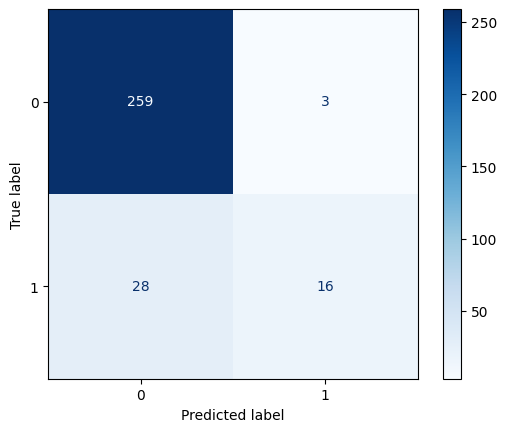

In [27]:
# Confusion Matrix
cm = confusion_matrix(Y_test, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()